# An R Intro to Bayesian Data Analysis

In this post, I will be going over some basics of Bayesian data analysis, based off of chapters 1-3 of *Statistical Rethinking, 2nd Edition* by Richard McElreath. In addition to providing some background, I will go over some basic methods for approximating and sampling from a posterior distribution. I will use R to apply each of these methods to a dataset of Near Earth Objects.


## Bayesian Data Analysis

**Bayesian probability** is an interpretation of probability as a state of belief: a more probable event is one that we believe to be more likely. In contrast, frequentist probability treats probability as the frequency of an event over a large number of samples: as we keep drawing more samples, the ratio of a given event converges to the probability of that event.

Bayesian probability is a particularly intuitive framework for data analysis because it meshes well with the concept of learning from data. In statistical data analysis, a model represents our belief of some structure underlying our data. Then learning -- updating the model based on the data -- corresponds to conditioning that belief on the data. In other words, this is Bayes' Theorem. 

Concretely, consider a case where we are flipping a weighted coin. Our data $D$ is a sequence of observed coin flips, heads and tails. The variable controlling the data's dynamics $C$ could consist of a single parameter, the probability that coin will land on heads. Then we can write Bayes' Theorem:

$$P(C \mid D) = \frac{P(D \mid C) P(C)}{P(D)}$$
* $P(C)$ is the **prior belief**, the model before learning. For example, if we believe any weighting is equally likely, then $P(C)$ is the uniform distribution from 0 to 1.
* $P(C \mid D)$ is the **posterior belief**, the model after learning from data. This is a distribution over weightings, based on which ones are more likely given the observed flips.
* $P(D \mid C)$ is the **likelihood** of the data given a value of the structure. For a given coin weighting, it represents how likely our sequence of coin flips would have been.
* $P(D)$ is some likelihood of the data. In practice, this is often treated as a regularization term since it is constant across structures.

In short, we derive a posterior model from a prior model based on how well the model fits the data. The analysis workflow thus consists of designing a model and updating its beliefs to a posterior. Given this posterior, which represents our beliefs over the data, we can retrieve some information from characteristics of the data, such as uncertainty.
With this in mind, we will go over a concrete example using an astronomy dataset, by designing a model for the data, going over a few ways to estimate the posterior, and using sampling to extract information about the learned posterior.

## Data: Near Earth Objects

We will be working with the [Near Earth Object](https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects) dataset hosted on Kaggle. It consists of over 90,000 Near Earth Objects (NEOs) recognized by NASA, each with some information about its size and trajectory, in addition to a binary labels as to whether it is hazardous.

A potential goal of this dataset is to use information about each NEO to predict whether it is hazardous or safe. In this post, let's simply work with the hazardous labels, and address the question: **How likely is a NEO to be hazardous?**

*Side note:* Because this dataset is based off of *observed* NEOs, the data inherits any observation bias from which objects are observed. However, for the sake of simplicity, I will treat the data as unbiased, random samples of NEOs.

We can start by loading the data (downloaded from Kaggle) and see what it looks like.

In [1]:
# Load in the data
data <- read.csv("neo_v2.csv")
head(data, 5)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
1,2162635,162635 (2000 SS164),1.19827080,2.6794150,13569.25,54839744,Earth,False,16.73,False
2,2277475,277475 (2005 WK4),0.26580000,0.5943469,73588.73,61438127,Earth,False,20.00,True
3,2512244,512244 (2015 YE18),0.72202956,1.6145072,114258.69,49798725,Earth,False,17.83,False
4,3596030,(2012 BV13),0.09650615,0.2157943,24764.30,25434973,Earth,False,22.20,False
5,3667127,(2014 GE35),0.25500869,0.5702168,42737.73,46275567,Earth,False,20.09,True


In [2]:
sprintf("%i total examples", nrow(data))
total_counts <- table(data$hazardous)
total_H <- total_counts["True"]
total_S <- total_counts["False"]
sprintf("%i safe, %i hazardous", total_S, total_H)

[1] "90836 total examples"

[1] "81996 safe, 8840 hazardous"

## Model Design

As we can see, each NEO is labeled as safe or hazardous. Our problem setup is to model how likely a random NEO is to be hazardous. Because we are not using any of the auxiliary information, we can design a simple model as follows: Assume each sampled NEO has the same chance of being hazardous, $p$. In other words, the data generation process for a random NEO is a Bernoulli random variable, where each NEO is hazardous with probability $p$ and safe with probability $1 - p$. In this system, we have **observed variables** $H$ (the number of hazardous samples observed) and $S$ (the number of safe samples observed), which inform us about the **unobserved variable (parameter)** $p$. For each parameter, we also need to pick a **prior distribution** over possible values. For example, we will initially assume that any value of $p$ is equally likely, so our prior is $p \sim \mathcal{U}(0, 1)$ or $P(p) = 1$.

## Updating the Model

Given this model design, the next step is to update the model -- that is, use the observed variable values to calculate a **posterior distribution** over parameters based on the observed data. In other words, we want to find the distribution $p \mid H, S$. When we apply Bayes' Theorem, it turns out that

$$P(p \mid H, S) = \dfrac{P(H, S \mid p) P(p)}{P(H, S)} = \dfrac{P(H, S \mid p) P(p)}{\int P(H, S \mid p') P(p') dp'} = f(H, S) p^H(1 - p)^S,$$

where $f(H, S)$ is a function that is constant with respect to $p$.

Although this scenario has the analytical solution $p \mid H, S \sim \mathcal{\beta}(H+1, S+1)$, in practice we are generally unable to compute an analytical solution this way. Although it is usually possible to calculate to numerator in Bayes theorem for individual values of $p$, the integral $\int P(H, S \mid p') P(p') dp'$ is intractable over high dimensional parameter spaces and complex likelihood functions. If it were feasible to perform this calculation, high-dimensional problems like image classification would be much easier!

This is why we usually only care about using Bayes' Theorem up to proportionality: $P(p \mid H, S) \propto P(H, S \mid p) P(p)$.

With analytical solutions off the table, we instead turn to methods for **approximating the posterior**. As in *Rethinking Statistics*, we will go over grid approximation, quadratic approximation, and Markov chain Monte Carlo.

Here is what the true posterior distribution looks like:

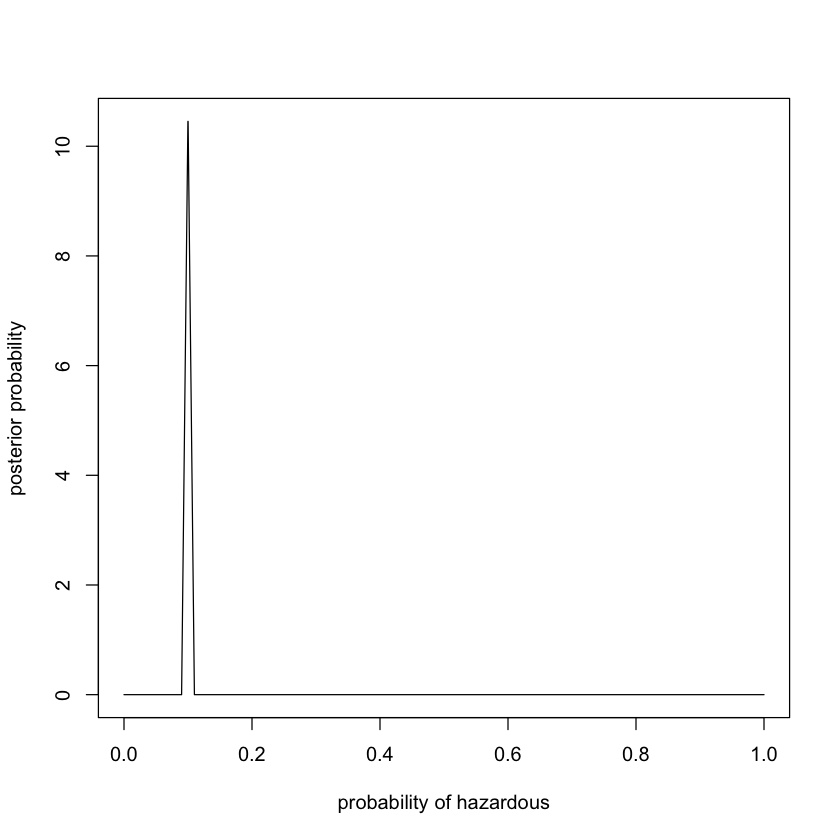

In [3]:
par(bg="white")
curve(dbeta(x, total_H+1, total_S+1), from=0, to=1, 
      xlab="probability of hazardous", ylab="posterior probability")

The posterior distribution becomes very narrow with as many samples as the whole dataset. Based on the observations, we become fairly certain that the probability of an NEO being hazardous is somewhere a bit under 0.1. This is not very conducive to helpful visualizations, so we first downsample the dataset to 20 datapoints. However, the same methods can be applied to the whole dataset in exactly the same way.

In [4]:
set.seed(121)
sample_size <- 20
sample <- data[sample(nrow(data), sample_size), ]

In [5]:
counts <- table(sample$hazardous)
H <- counts["True"]
S <- counts["False"]
H <- ifelse(is.null(H), 0, H)
S <- ifelse(is.null(S), 0, S)
sprintf("%i safe, %i hazardous", S, H)
sprintf("proportion hazardous samples = %f", H / (H + S))

[1] "17 safe, 3 hazardous"

[1] "proportion hazardous samples = 0.150000"

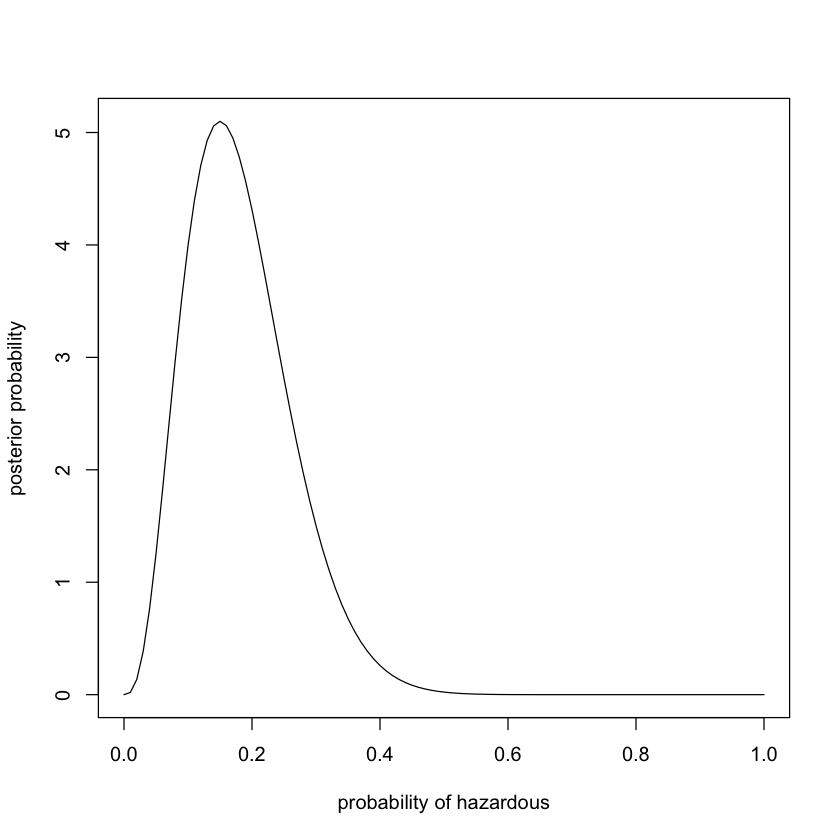

In [6]:
par(bg="white")
curve(dbeta(x, H+1, S+1), from=0, to=1, 
      xlab="probability of hazardous", ylab="posterior probability")

As we can see, with only 20 samples, we are much less confident in our estimate of $p$ -- the distribution is wider and reflects that randomness has a higher impact on smaller samples.

We will be using the `rethinking` package -- to install it, follow the instructions at [this Github repo](https://github.com/rmcelreath/rethinking)

In [7]:
library(rethinking)
library(glue)

Loading required package: parallel

Warning message in (function (n) :
"strings not representable in native encoding will be translated to UTF-8"
Warning message in (function (n) :
"strings not representable in native encoding will be translated to UTF-8"
Warning message in (function (n) :
"strings not representable in native encoding will be translated to UTF-8"
rethinking (Version 2.13.2)


Attaching package: 'rethinking'


The following object is masked from 'package:stats':

    rstudent




### Grid approximation

**Grid approximation** takes advantage of the relative feasibility of calculating individual points along the probability distribution. By deriving estimates of the posterior along a grid of parameter values, we can get a rough picture of the posterior distribution. 

Here's how it works concretely. We define a finite set of parameter values as a grid through the parameter space. Since the product of the likelihood and the prior is proportional to the posterior, grid approximation calculates the product $P(H, S \mid p) P(p)$ at each value of $p$ along the grid. By normalizing these values afterwards, we can obtain a rough approximation of the posterior distribution.

Let's do this in R!

In [8]:
# Grid approximation with uniform prior
grid_approx <- function(H, S, n_points=20) {
   p <- seq(from=0, to=1, length.out=n_points)     # construct grid of parameter values
   prior <- rep(1, n_points)                       # value of prior at each value of p
   likelihood <- dbinom(H, size=H+S, prob=p)       # likelihood at each value of p
   posterior <- likelihood * prior
   posterior <- posterior / sum(posterior)         # normalize to sum to 1
   return(list(p=p, posterior=posterior))
}

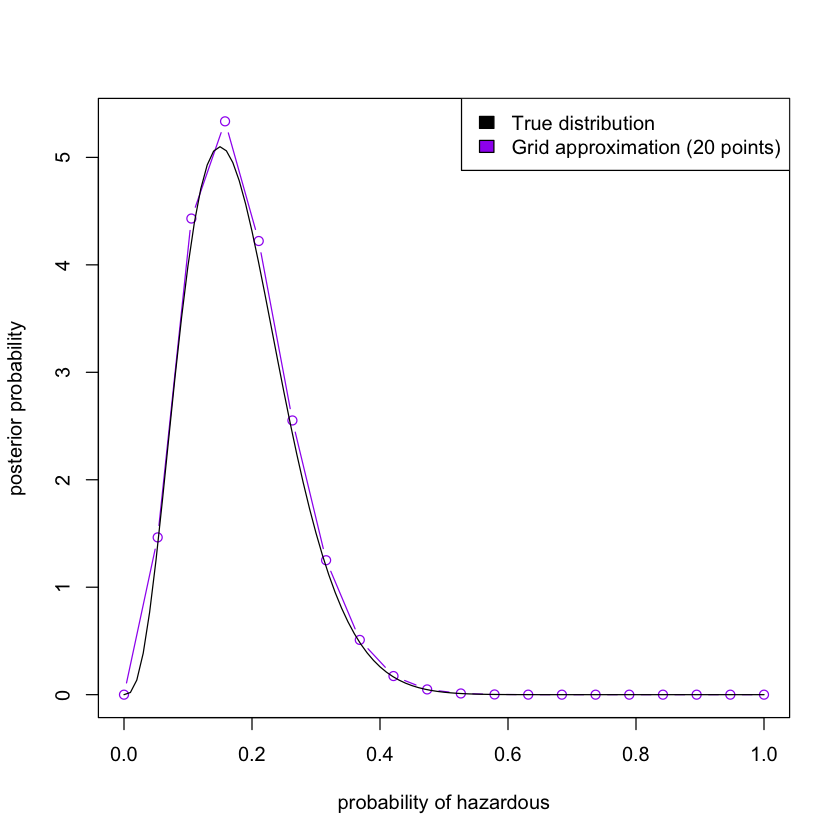

In [9]:
n_points <- 20
output_grid <- grid_approx(H, S, n_points=n_points)
par(bg="white")
plot(output_grid$p, n_points * output_grid$posterior, type="b", col="purple",
     xlab="probability of hazardous", ylab="posterior probability")
curve(dbeta(x, H+1, S+1), add=TRUE)
legend(x="topright", legend=c("True distribution", glue("Grid approximation ({n_points} points)")), 
       fill = c("black","purple")
)

As we can see, the grid approximation points are pretty close to the actual distribution! However, although grid approximation is simple and intuitive, it is not very useful in practice. The quality of the approximation is dependent on the density of points on the grid -- if there are too few points, we only get a very coarse image of the posterior distribution. moreover, the size of the grid grows exponentially with the dimensionality of the parameter space, so for most realistic problems it is unscalable. 

### Quadratic approximation

**Quadratic approximation**, in short, fits a Gaussian distribution to the posterior distribution. By constraining the posterior of the model to a Gaussian, which is only parameterized by its mean and variance, quadratic approximation massively reduces the computational overhead compared to grid approximation. Because the log of the Gaussian is a parabola, fitting a parabola to the log posterior is equivalent to fitting a Gaussian to the posterior. We simply fit a parabola to the log posterior by locating its peak (corresponding to the mean) and computing the second derivative at that point (corresponding to the variance).

Here's how we do it:

In [10]:
quad_approx <- function(H, S) {
    neo.qa <- quap(
        alist(
            H ~ dbinom(H+S, p), # binomial likelihood
            p ~ dunif(0,1) # uniform prior
        ),
        data=list(H=H,S=S) 
    )
    stats <- precis(neo.qa)
    return(list(mean=stats$mean, sd=stats$sd))
}
output_quad <- quad_approx(H, S)

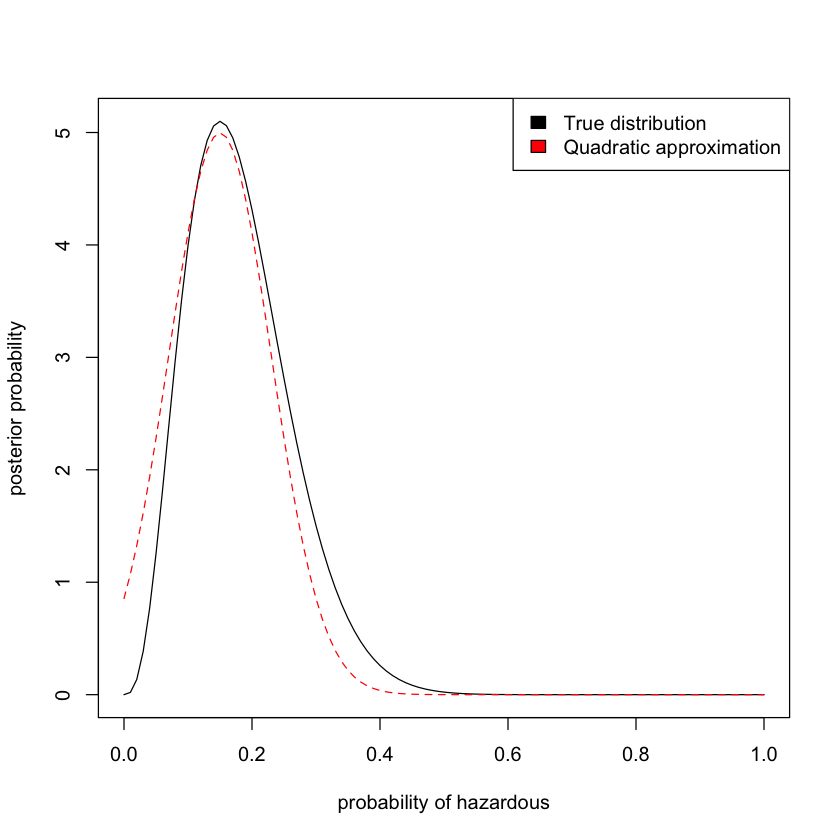

In [11]:
# analytical calculation
par(bg="white")
curve(dbeta(x, H+1, S+1), from=0, to=1, 
      xlab="probability of hazardous", ylab="posterior probability")
# quadratic approximation
curve(dnorm(x, output_quad$mean, output_quad$sd), lty=2, col="red", add=TRUE)
legend(x="topright", legend=c("True distribution", "Quadratic approximation"), 
       fill = c("black","red")
)

As we can see above, the quadratic approximation roughly matches the true distribution in its mode and width, but is not able to match the distribution perfectly. This is generally the case -- unlike grid approximation, quadratic approximation will not approach the true posterior distribution if it is not Gaussian. This can be a problem in some cases, such as multimodal distributions that cannot be fit well with a Gaussian. However, in many practical situations, a Gaussian approximation is good enough for use, especially because it is computationally efficient.

### Markov Chain Monte Carlo

**Markov chain Monte Carlo (MCMC)** is a family of methods that differ from grid and quadratic approximation in that they do not directly model the posterior distribution. Instead, MCMC methods generate samples from the posterior distribution. The general idea is to take a random walk over the parameter space, guided by a tendency toward higher posterior density points. Then samples along the random walk (which each correspond to sets of parameter values) become distributed as the true posterior distribution. 

Here is an implementation of the Metropolis algorithm, which is one MCMC algorithm.

In [12]:
mcmc_approx <- function(H, S, n_samples=1000, p_init=0.5, step_size=0.1) {
    p <- rep(NA, n_samples)
    p[1] <- p_init
    for (i in 2:n_samples) {
        p_new <- rnorm(1, p[i-1], step_size)
        if (p_new < 0) p_new <- abs(p_new)
        if (p_new > 1) p_new <- 2 - p_new
        q0 <- dbinom(H, H+S, p[i-1])
        q1 <- dbinom(H, H+S, p_new)
        p[i] <- ifelse( runif(1) < q1/q0 , p_new , p[i-1] )
    }
    return(p)
}
n_samples <- 1000
p_mcmc <- mcmc_approx(H, S, n_samples=n_samples)

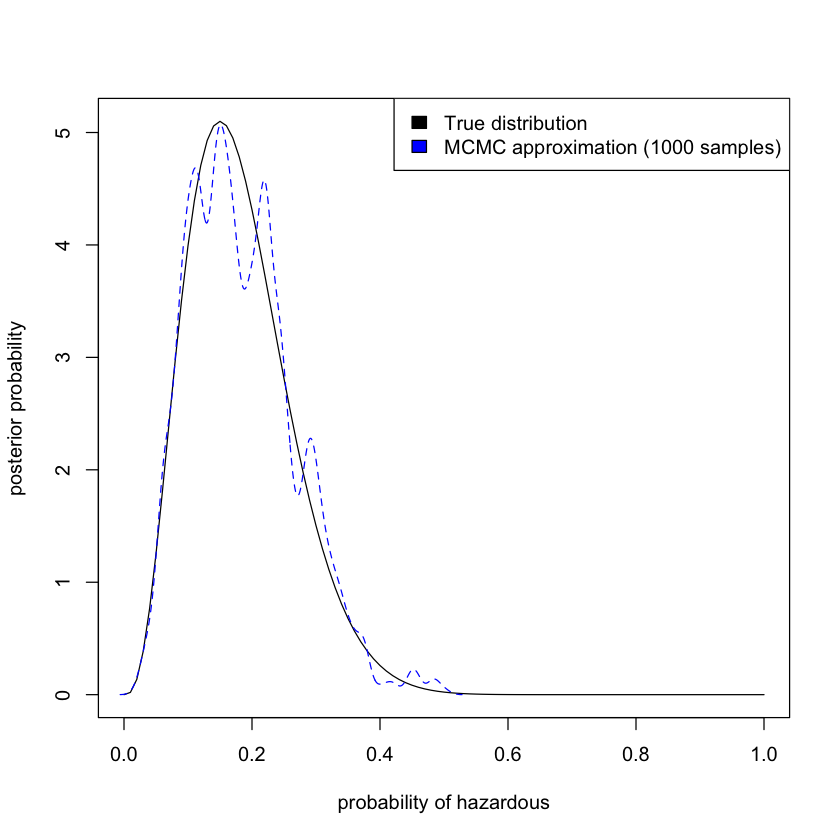

In [13]:
par(bg="white")
curve(dbeta(x, H+1, S+1), from=0, to=1, 
      xlab="probability of hazardous", ylab="posterior probability")
dens(p_mcmc, xlim=c(0,1), lty=2, col="blue", add=TRUE)
legend(x="topright", legend=c("True distribution", glue("MCMC approximation ({n_samples} samples)")), 
       fill = c("black","blue")
)

As we can see above, the MCMC approximation is relatively noisy because of the random walk. Because we are generating samples and consecutive samples are close to each other, it can take a large number of steps to get an accurate representation of the posterior distribution. With higher dimensional parameter spaces, such as with deep neural networks, this could mean storing an unreasonable number of sets of weights. However, MCMC does have the guarantee of converging to the true posterior with enough samples -- as shown below, increasing the number of samples brings the density of samples extremely close to the true posterior distribution.

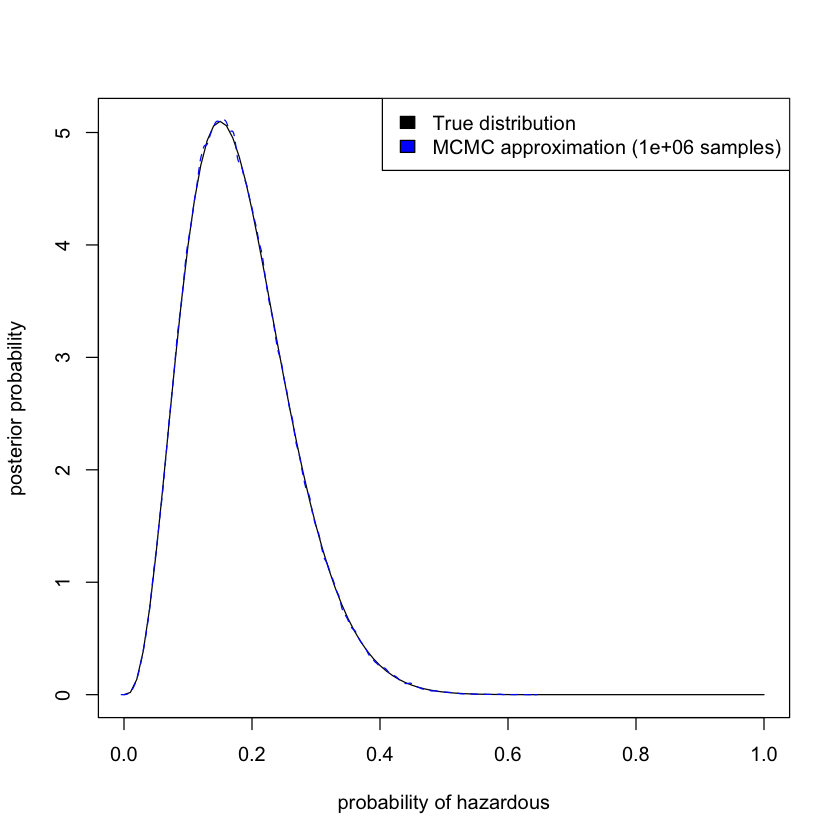

In [14]:
n_samples_limit <- 1e6
p_mcmc_limit <- mcmc_approx(H, S, n_samples=n_samples_limit)
par(bg="white")
curve(dbeta(x, H+1, S+1), from=0, to=1, 
      xlab="probability of hazardous", ylab="posterior probability")
dens(p_mcmc_limit, xlim=c(0,1), lty=2, col="blue", add=TRUE)
legend(x="topright", legend=c("True distribution", glue("MCMC approximation ({n_samples_limit} samples)")), 
       fill = c("black","blue")
)

## All together
We can put all of the graphs on one plot for comparison.

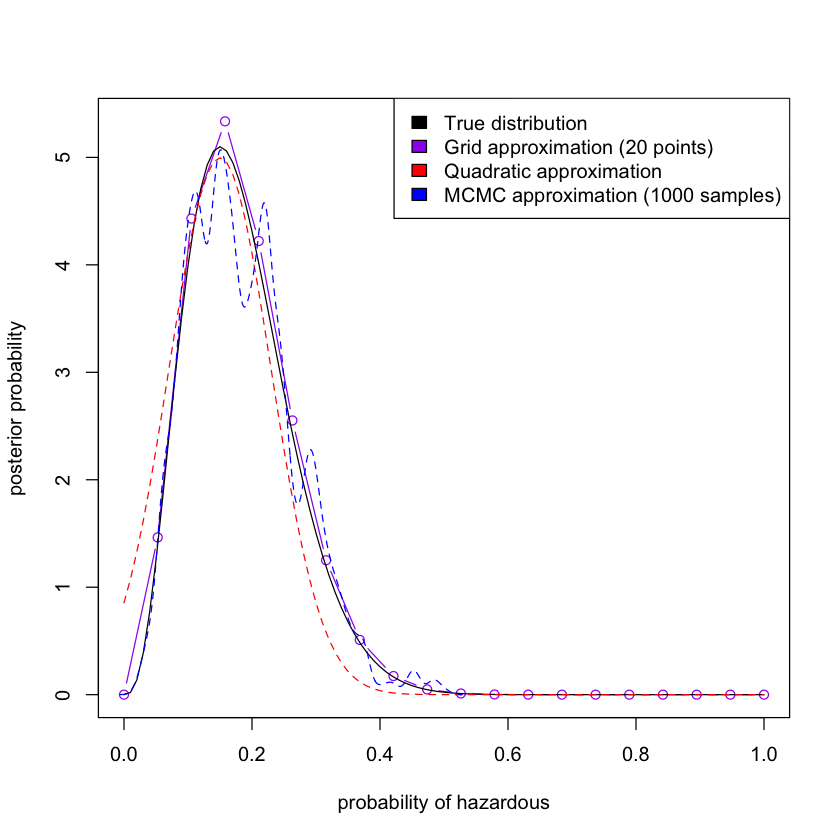

In [15]:
par(bg="white")
plot(output_grid$p, n_points * output_grid$posterior, type="b", col="purple",
     xlab="probability of hazardous", ylab="posterior probability")
curve(dbeta(x, H+1, S+1), from=0, to=1, add=TRUE)
curve(dnorm(x, output_quad$mean, output_quad$sd), lty=2, col="red", add=TRUE)
legend(x="topright", legend=c("True distribution", "Quadratic approximation"), 
       fill = c("black","red")
)
dens(p_mcmc, xlim=c(0,1), lty=2, col="blue", add=TRUE)
legend(x="topright", legend=c("True distribution", glue("Grid approximation ({n_points} points)"), "Quadratic approximation", glue("MCMC approximation ({n_samples} samples)")), 
       fill = c("black", "purple", "red", "blue")
)

## Sampling

After getting a posterior distribution that reflects our beliefs about patterns in the data, we can derive various summary quantities that inform us about properties of the distribution. Although these calculations can be done directly on the posterior, McElreath makes the interesting argument for teaching through sampling, because it is often more intuitive than integrating over a distribution. Moreover, certain methods like MCMC only generate samples, so making calculations on those samples is an important part of such methods.

Of course, there are other applications of sampling, such as data generation and checking if models are reasonable.

We can generate the samples for each of the posterior approximation methods above as follows.

In [16]:
n_samples <- 1e4
samples_grid <- sample(output_grid$p, prob=output_grid$posterior, 
                  size=n_samples, replace=TRUE)
samples_quad <- pmax(0, pmin(rnorm(n_samples, output_quad$mean, output_quad$sd), 1))
samples_mcmc <- mcmc_approx(H, S, n_samples=n_samples)

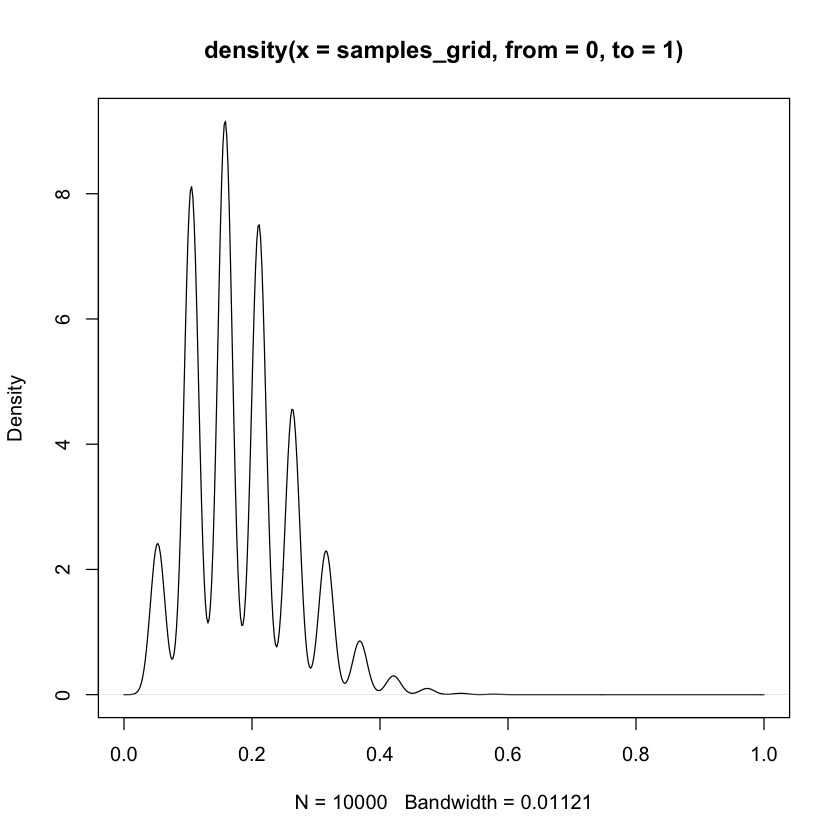

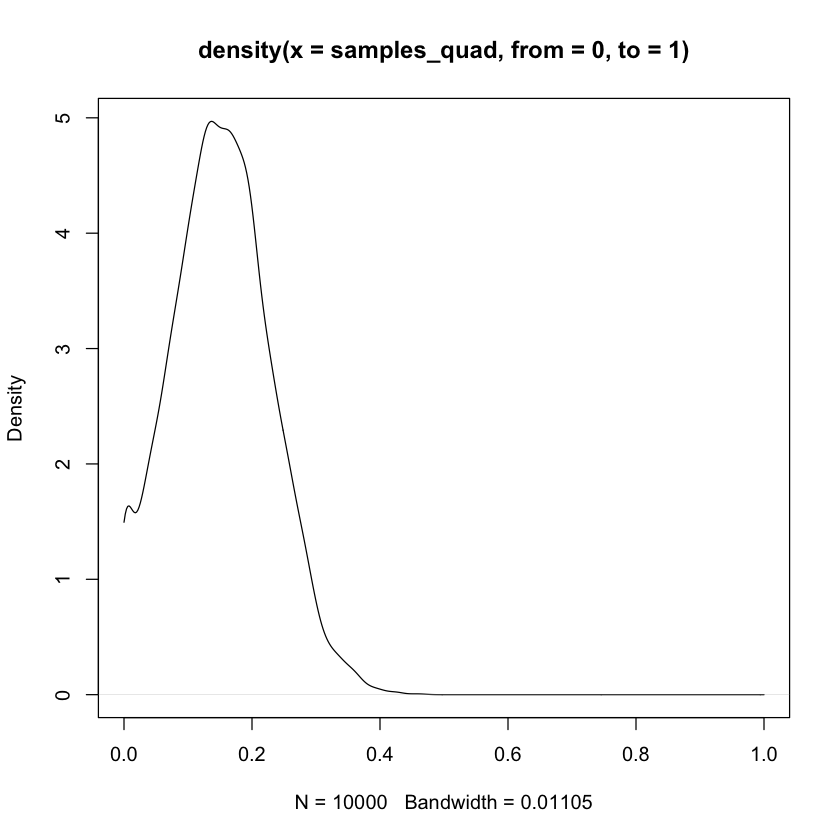

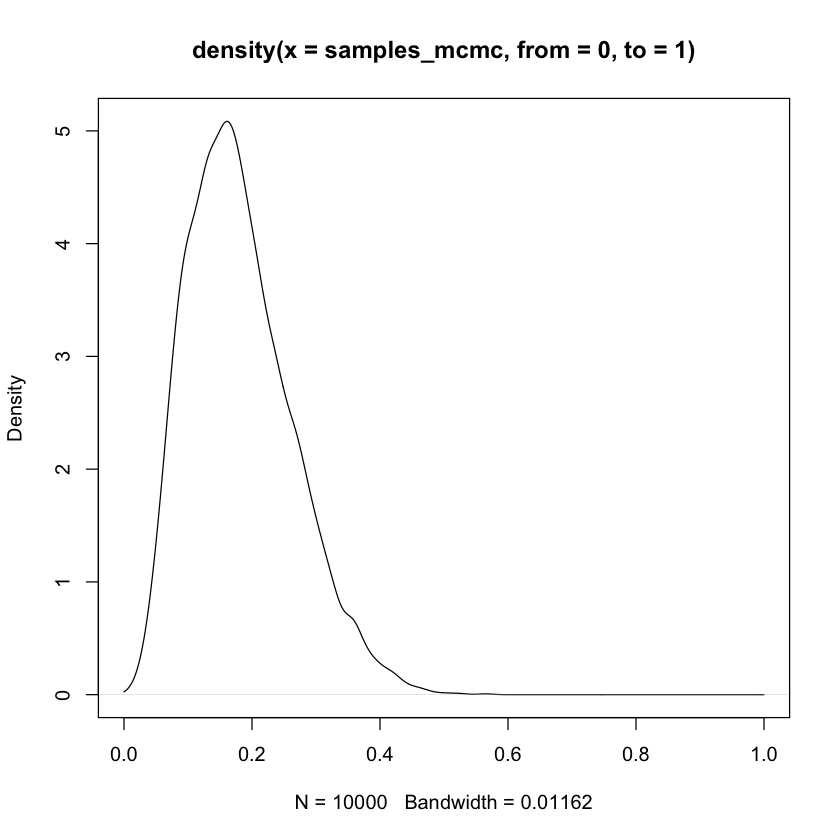

In [17]:
par(bg="white")
plot(density(samples_grid, from=0, to=1))
plot(density(samples_quad, from=0, to=1))
plot(density(samples_mcmc, from=0, to=1))

As we can see from the plots, the density of samples is generally representative of each posterior approximation. We can then estimate various types of summary information from the samples. Here are some of the questions we can answer with their corresponding code, using the MCMC samples generated above:

According to the posterior, how likely are the parameters to be in a certain interval?

In [18]:
# How much of the posterior is p < 0.3? 
# How likely is it that less than 30% of NEOs are hazardous?
sum(samples_mcmc < 0.3) / n_samples 

[1] 0.9125

In [19]:
# How much of the posterior is 0.5 < p < 0.75?
# How likely is it that between 50% and 75% of NEOs are hazardous?
sum(samples_mcmc > 0.5 & samples_mcmc < 0.75) / n_samples

[1] 6e-04

Where are the boundaries that divide the posterior by percentages of the total mass?

In [20]:
# Where is the boundary below which lie 80% of the samples/posterior mass?
# At what threshold are we 80% certain that the hazardous probability is lower?
quantile(samples_mcmc, 0.8)

80% 
0.2479472

In [21]:
# Where is the interval that has 10% of the samples below and 30% above?
# At what thresholds are we 10% certain that the hazardous probability is below, and 30% that it is over?
quantile(samples_mcmc , c(0.1 , 0.7))

10%        70% 
0.08416052 0.21646725

In [22]:
# Where is the central 50% of the samples?
# At what thresholds are we 25% certain that the hazardous probability is below, and 25% that it is over?
PI(samples_mcmc , prob=0.5)

25%       75% 
0.1203519 0.2316762

In [23]:
# Where is the narrowest interval that contains 50% of the samples?
# What is the smallest interval of values that we are over 50% confident the hazardous probability is in?
HPDI( samples_mcmc , prob=0.5 )

|0.5       0.5| 
0.09578702 0.20220859

Where is a representative value of the distribution?

In [24]:
# Finds the single value that we are most confident might be the hazardous probability?
chainmode(samples_mcmc, adj=0.01)

[1] 0.1676808

In [25]:
# Finds the average hazardous probability estimate
mean(samples)

ERROR: Error in eval(expr, envir, enclos): object 'samples' not found


In [ ]:
# Finds the central estimate at the 50% quantile
median(samples)

[1] 0.1578947

For any sampled parameter value $p$, we can also reverse the process and sample observations (data) given that value. This has several uses, including giving a picture of what the values in the posterior actually mean in terms of what the data looks like concretely.

[1] "Sampled value of p: 0.112677"

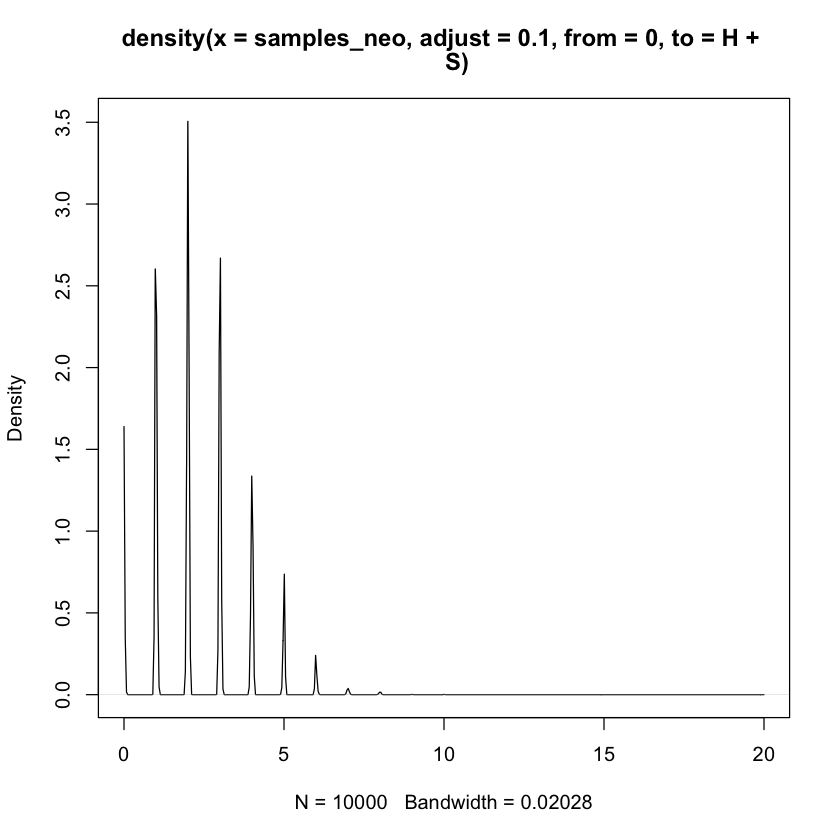

In [ ]:
p <- samples_mcmc[length(samples_mcmc)]
sprintf("Sampled value of p: %f", p)
samples_neo <- rbinom(1e4, (H + S), p)
par(bg="white")
plot(density(samples_neo, from=0, to=H+S, adj=0.1))

This distribution answers the question: If $p$ takes on the sampled value, how many NEOs in a sample of 20 is likely to be hazardous. In other words, it tells us what observations would look like for a particular value in the posterior. This can give us a way to judge how reasonable our posterior is. If our original sample is particularly unlikely in a sampled distribution of observations, then our posterior is less likely to be a good fit. Of course, in this example we do not really need to inspect the observations to tell if a value of $p$ is reasonable. But with more complex models, we often do not have good intuition about which posterior values are better. For example, if we design a model to classify images, it would be helpful to sample specific parameter values and generate characteristic images for each set of parameters. This could help us validate the posterior based on if the images look reasonable.